In [1]:
import sys
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/gcta/scripts')

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from compile_gcta_df import *
import statsmodels.stats.multitest as multi
from adjustText import adjust_text

In [3]:
import scipy
from scipy import stats

In [4]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### run make-grm.sh

Run script to construct GRMs for TCGA

### run run-gcta-european.sh

Run GREML analysis for all immune phenotypes

### Get GCTA results for Sailfish, FireBrowse, PanCanAtlas

In [6]:
def fdr(df,pseudo):
    #make heritability estimate numeric
    df["V(G)/Vp"]=pd.to_numeric(df["V(G)/Vp"])
    #add pseudocount
    if pseudo == True:
        df["Pval"]=df["Pval"]+0.0000001
    
    #calculate benjamin-hochberg fdr
    genes=df["gene"].tolist()
    probabilities = df["Pval"].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)


In [7]:
pseudocount=True

In [8]:
results=[""]
tpm=compile_gcta_results(results,output="overall",direct="/cellar/users/mpagadal/Data/projects/germline-immune/heritability/results/tpm/full/")
firebrowse=compile_gcta_results(results,output="overall",direct="/cellar/users/mpagadal/Data/projects/germline-immune/heritability/results/firebrowse/full/")
pancan=compile_gcta_results(results,output="overall",direct="/cellar/users/mpagadal/Data/projects/germline-immune/heritability/results/pancanatlas/full")

compiling gene level heritability dataframe.....


/cellar/users/mpagadal/Data/gcta/scripts/compile_gcta_df.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variance["V(G) SE"]=se[0].tolist()
/cellar/users/mpagadal/Data/gcta/scripts/compile_gcta_df.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variance["V(e) SE"]=se[1].tolist()
/cellar/users/mpagadal/Data/gcta/scripts/compile_gcta_df.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

compiling gene level heritability dataframe.....
compiling gene level heritability dataframe.....


In [9]:
tpm=fdr(tpm,pseudocount)
firebrowse=fdr(firebrowse,pseudocount)
pancan=fdr(pancan,pseudocount)

In [11]:
# rename columns to merge for total dataframe

tpm=tpm.rename(columns={"V(G)/Vp":"tpm V(G)/V(p)","-log10(fdr)":"tpm -log10(fdr)"})
firebrowse=firebrowse.rename(columns={"V(G)/Vp":"firebrowse V(G)/V(p)","-log10(fdr)":"firebrowse -log10(fdr)"})
pancan=pancan.rename(columns={"V(G)/Vp":"pancan V(G)/V(p)","-log10(fdr)":"pancan -log10(fdr)"})

# merge columns

total=pd.merge(tpm[["tpm V(G)/V(p)","gene","tpm -log10(fdr)"]],firebrowse[["firebrowse V(G)/V(p)","gene","firebrowse -log10(fdr)"]], on="gene",how="outer")
total=pd.merge(total,pancan[["pancan V(G)/V(p)","gene","pancan -log10(fdr)"]],on="gene",how="outer")

In [12]:
#g et number of RNA processing pipelines that support V(G)/V(p) > 0.05 and -log10(fdr) > 1.3
total["consensus V(g)/V(p)"]=total[["tpm V(G)/V(p)","firebrowse V(G)/V(p)","pancan V(G)/V(p)"]].apply(lambda x: len([x for x in list(x) if x>0.05]), axis=1)
total["consensus fdr"]=total[["tpm -log10(fdr)","firebrowse -log10(fdr)","pancan -log10(fdr)"]].apply(lambda x: len([x for x in list(x) if x>1.3]), axis=1)

In [13]:
# keep only genes with phenotype values in at least 2 datasets
total["null"]=total[["tpm V(G)/V(p)","firebrowse V(G)/V(p)","pancan V(G)/V(p)"]].apply(lambda x: len([x for x in list(x) if np.isnan(x)]), axis=1)
total=total[total["null"]<2]
df_genes=pd.DataFrame({"genes":total["gene"].tolist()})
#df_genes.to_csv("immune.genes.2.rna.txt",index=None,sep="\t")

In [14]:
len(df_genes)

741

In [15]:
# make column of size of scatterplot
total["size"]=(total["consensus V(g)/V(p)"]*30)+10

In [17]:
# map to category
with open('/cellar/users/mpagadal/Data/projects/germline-immune/discovery/data/pheno_dictionary.json', 'r') as f:
    pheno_dict = json.load(f)
total["category"]=total["gene"].map(pheno_dict)

In [18]:
# significant heritability genes
# at least 2 rna sources with heritability estimates > 0.05
# at least 1 of the heritability estimates must have FDR > 10%
sig=total[(total["consensus V(g)/V(p)"]>1)&(total["consensus fdr"]>0)]["gene"].tolist()

In [19]:
len(sig)

137

In [23]:
# export significant heritable genes
gcta_sig=pd.DataFrame({"genes":sig})
gcta_sig.to_csv("../data/gcta_significant_genes.txt",header=None,index=None)

In [24]:
"There are {} heritable immune traits".format(len(sig))

'There are 137 heritable immune traits'

In [25]:
"The following immune genes are heritable: {}".format(" ".join(sig))

'The following immune genes are heritable: FCGR2A PSMD2 FPR1 CYBA IL1A CTSS PSMD11 C3AR1 LNPEP MICA COX17 LYN CD86 IFI44L CSF3R SKIL TAP2 ERAP1 ENTPD1 SLC25A40 ENO1 OAS3 HLA.C UAP1 KIF2A APITD1 MARCH1 PLEK DYNLT1 IL10 MARVELD2 RNF41 LYZ SEC24C ITGAV CD80 TRA2B MYO1F DBNDD1 CCBL2 CAPZB PSMC1 WDR54 B2M NUTF2 DHFR MNDA HLA.DQA1 VAMP3 IGF2R FCGR3A TAB1 PSMB9 BTN3A2 LM22.Macrophages.M2 PSMB7 LAIR1 SAMHD1 IL2RA ALOX5AP CLEC4A MS4A4A DCTN5 IL12A HLA.B PIK3CG SLC11A1 HLA.DRB5 HCK CANX FCGR3B GNPTAB LILRB2 ADCY7 HLA.A CD44 HLA.F GPLD1 PGM2 OAS1 HLA.DRB1 HAUS1 SMAD4 CBX1 NEO1 CTSD BSG IFI6 STAT1 CD84 SEC31A TNFRSF1A COL8A1 CD209 RAB35 CHUK CTNNB1 RBM14 VSIG4 FPR3 HLA.DQA2 NCF2 EIF2AK1 PLOD2 ITGB2 SEC22B CSF1R CAPZA2 SIGLEC5 FAM167A LILRB4 TNFSF13B TREX1 AMPD3 CD14 CD68 FCGR2B IL1B IL10RA CYBB MICB CTSW CD163 SLC25A5 CD53 ERLIN1 SH3BP5L CTSL ISG15 TRAF6 TLR2 ERAP2 HLA.DQB1 SEC24A HLA.DQB2 HLA.G HLA.H'

In [26]:
total[total["gene"].isin(sig)]["category"].value_counts()

immunomodulators       70
antigen present        41
immune checkpoint      11
cell type              10
TGFbeta                 3
immune infiltration     1
IFNG                    1
Name: category, dtype: int64

In [27]:
# color based on category
total["color"]="silver"
total["color"]=np.where((total['consensus V(g)/V(p)']>1), "silver",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="antigen present"),"#66c2a5",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="immunomodulators"),"#fc8d62",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="immune checkpoint"),"#8da0cb",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="cell type"),"#e78ac3",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="TGFbeta"),"#a6d854",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="IFNG"),"#ffd92f",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="immune infiltration"),"#e5c494",total.color)

In [29]:
# label only genes with heritability > 0.10
df_label=total[(total["color"]!="silver")&(total["tpm V(G)/V(p)"]>0.10)]

In [30]:
mp_color={"#66c2a5":"antigen present","#fc8d62":"immunomodulators","#8da0cb":"immune checkpoint","#e78ac3":"cell type","#a6d854":"TGFbeta","#ffd92f":"IFNG","#e5c494":"immune infiltration","silver":""}

In [31]:
# get max heritability and log10 FDR
total["max V(g)/V(p)"]=total[["tpm V(G)/V(p)", "firebrowse V(G)/V(p)","pancan V(G)/V(p)"]].max(axis=1)
total["max log10fdr"]=total[["tpm -log10(fdr)", "firebrowse -log10(fdr)","pancan -log10(fdr)"]].max(axis=1)

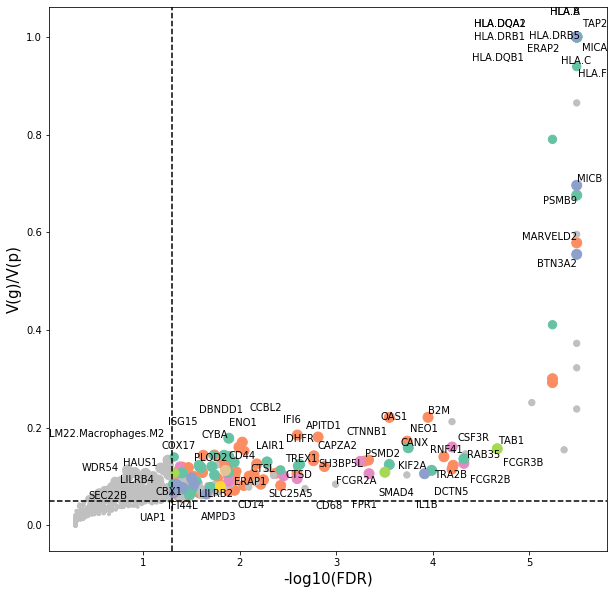

In [33]:
f=plt.figure(figsize=(10,10))
for x in total["color"].unique():
    sc=plt.scatter(total[total["color"]==x]["max log10fdr"],total[total["color"]==x]["max V(g)/V(p)"],
                color=total[total["color"]==x]["color"],s=total[total["color"]==x]["size"],label=mp_color[x])

plt.ylabel("V(g)/V(p)",fontsize=15)
plt.xlabel("-log10(FDR)",fontsize=15)
plt.axvline(x=1.3,color="k",linestyle="--")
plt.axhline(y=0.05,color="k",linestyle="--")

texts=[]
for i,row in df_label.iterrows(): 
    texts.append(plt.text(float(row["tpm -log10(fdr)"]),float(row["tpm V(G)/V(p)"]),row["gene"],color="black"))
    
adjust_text(texts,only_move={'points':'y', 'texts':'y'}, color='black', lw=0.5)

# kw = dict(prop="sizes", num=5, color="k",
#           func=lambda s: (s-10)/30)
# plt.legend(*sc.legend_elements(**kw),
#                     loc="upper left", title="Consensus")

f.savefig("../plots/consensus-heritability-barplot.pdf", bbox_inches='tight')


## Get HLA-nonHLA information

In [35]:
# get heritability results from two-state nonHLA and HLA analysis
nonhla=pd.read_csv("../data/nonhla_gcta_results.tsv",delimiter="\t")
hla=pd.read_csv("../data/hla_gcta_results.tsv",delimiter="\t")
df_hla=pd.merge(nonhla,hla,on=["gene"],suffixes=("_nonhla","_hla"))

In [36]:
df_hla["tpm diff"]=df_hla["tpm V(G)/V(p)_nonhla"]-df_hla["tpm V(G)/V(p)_hla"]
df_hla["firebrowse diff"]=df_hla["firebrowse V(G)/V(p)_nonhla"]-df_hla["firebrowse V(G)/V(p)_hla"]
df_hla["pancan diff"]=df_hla["pancan V(G)/V(p)_nonhla"]-df_hla["pancan V(G)/V(p)_hla"]

In [37]:
df_hla["consensus nonhla"]=df_hla[["tpm diff","firebrowse diff","pancan diff"]].apply(lambda x: len([x for x in list(x) if x>0]), axis=1)

In [38]:
hla_genes=df_hla[(df_hla["gene"].isin(sig))&(df_hla["consensus nonhla"]<=2)]["gene"].tolist()
print(len(hla_genes))
" ".join(hla_genes)

17


'TAP2 PSMB9 MICA HLA.B HLA.C HLA.DQA1 HLA.DRB5 HLA.DRB1 HLA.DQA2 BTN3A2 HLA.DQB1 MICB HLA.A HLA.F HLA.DQB2 HLA.H HLA.G'

In [39]:
nonhla_genes=df_hla[(df_hla["gene"].isin(sig))&(df_hla["consensus nonhla"]>2)]["gene"].tolist()
print(len(nonhla_genes))
" ".join(nonhla_genes)

120


'LAIR1 PSMB7 EIF2AK1 FCGR3B IL2RA LYZ CD86 LILRB2 SKIL GNPTAB SIGLEC5 FAM167A CTSS DCTN5 B2M IL12A FPR1 CYBA IL1A TRA2B IL10 PLEK CCBL2 MYO1F SEC31A RNF41 ITGAV MARVELD2 SLC25A5 SLC25A40 VAMP3 COL8A1 UAP1 SH3BP5L CTNNB1 IGF2R OAS3 PSMC1 WDR54 CAPZB NUTF2 ENO1 KIF2A LYN DHFR MNDA SEC22B CAPZA2 LILRB4 CD80 C3AR1 COX17 IL10RA LNPEP FCGR2B PSMD2 ERLIN1 ERAP1 CSF3R SEC24A TAB1 OAS1 FCGR2A CD163 PGM2 PSMD11 CD44 ERAP2 IFI44L CANX ENTPD1 ISG15 TRAF6 ITGB2 FPR3 ALOX5AP PLOD2 APITD1 CHUK AMPD3 CD84 MARCH1 TNFRSF1A IFI6 SLC11A1 CSF1R CBX1 TREX1 NEO1 DYNLT1 CTSD SEC24C TNFSF13B HCK SMAD4 STAT1 DBNDD1 RBM14 VSIG4 RAB35 CD209 NCF2 FCGR3A TLR2 ADCY7 SAMHD1 CTSL MS4A4A LM22.Macrophages.M2 CD53 BSG CLEC4A GPLD1 PIK3CG HAUS1 CTSW IL1B CYBB CD14 CD68'

In [40]:
df_hla["max hla V(g)/V(p)"]=df_hla[["tpm V(G)/V(p)_hla", "firebrowse V(G)/V(p)_hla","pancan V(G)/V(p)_hla"]].max(axis=1)
df_hla["max nonhla V(g)/V(p)"]=df_hla[["tpm V(G)/V(p)_nonhla", "firebrowse V(G)/V(p)_nonhla","pancan V(G)/V(p)_nonhla"]].max(axis=1)

In [41]:
df_hla["difference"]=df_hla["max hla V(g)/V(p)"]-df_hla["max nonhla V(g)/V(p)"]

### Make HLA-nonHLA GCTA dataframe

In [42]:
plot_hla=df_hla.sort_values(by="difference",ascending=False)
plot_hla=plot_hla[plot_hla["gene"].isin(sig)]
plot_hla.shape

(137, 24)

In [43]:
plot_hla=pd.melt(plot_hla, id_vars=['gene'], value_vars=['max hla V(g)/V(p)', 'max nonhla V(g)/V(p)'])

([], <a list of 0 Text xticklabel objects>)

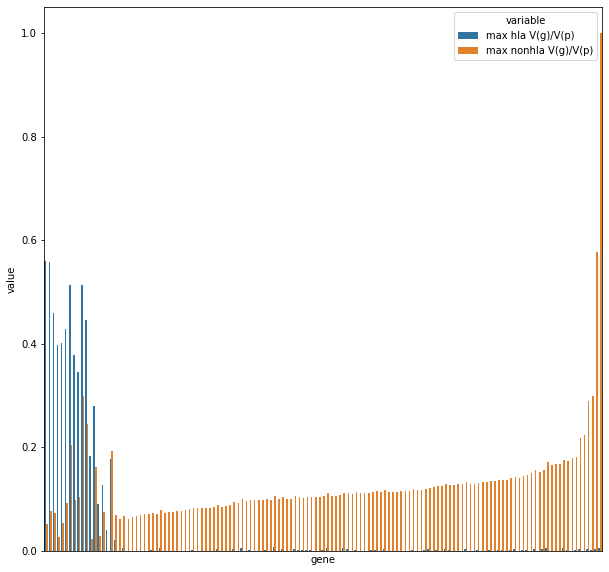

In [45]:
f=plt.figure(figsize=(10,10))
sns.barplot(x="gene", hue="variable", y="value", data=plot_hla)
plt.xticks(rotation=90)
f.savefig("../plots/heritability-hla-difference-barplot.pdf", bbox_inches='tight')
plt.xticks([])

## Export dataframe

In [47]:
total=total.set_index("gene")
total.head()

KeyError: "None of ['gene'] are in the columns"

In [48]:
df_gcta=pd.merge(total, df_hla[["gene","max hla V(g)/V(p)","max nonhla V(g)/V(p)"]].set_index("gene"),left_index=True,right_index=True,how="left")

In [49]:
df_gcta.to_csv("../data/tcga_gcta_analysis.csv")